In [1]:
from readfiles import *
import sys
import numpy.linalg as LA
import copy
from unit import *
from qutip import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Writing main Hamiltonian

In [2]:
# Now defining Units and conversion factors. 
h = 6.62607015e-34 # planck's constant in joules second
c = 2.99792458e10 # speed of light in cm per second
e = 1.60217663e-19 # charge of electron in coulombs
hbar = 0.658211951 # in eV-fs or meV-ps or ueV-ns
cm2ev = c*h/e  # conversion factor from 1/cm to eV
cm2mev = cm2ev * 1.e3  # conversion from 1/cm to meV
ev2au = e/4.3597447222071e-18  # converison from eV to atomic mass units
cm2au = cm2ev * ev2au  # conversion from 1/cm to atomic mass units

kB = 8.617333262e-2 # meV/K, Boltzmann constant

In [3]:
free_e_gyro = 28024.9514242E6 # Hz/T gyromagnetic ratio of an electron.
hz2meV = 4.1357E-12 # 1Hz = 4.1357E-15 eV = 4.1357E-12 meV
free_e_gfactor = 2.00231930437378 # free electron g factor 2.00231930437378
alpha = (free_e_gyro*hz2meV)/free_e_gfactor # gyromagnetic ratio/gfactor in meV per tesla
print("alpha in units of meV per tesla = "+str(alpha))
print("hbar is contained in the definition of alpha")

alpha in units of meV per tesla = 0.057884270182028845
hbar is contained in the definition of alpha


In [4]:
eS = jmat(1/2)
eS

(Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.  0.5]
  [0.5 0. ]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.+0.j  0.-0.5j]
  [0.+0.5j 0.+0.j ]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[ 0.5  0. ]
  [ 0.  -0.5]])

In [5]:
sigma_vec = [sigmax(), sigmay(), sigmaz()]
sigma_vec

[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0. 1.]
  [1. 0.]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.+0.j 0.-1.j]
  [0.+1.j 0.+0.j]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[ 1.  0.]
  [ 0. -1.]]]

In [6]:

# NOTE: using the pauli vector instead of spin half operators. Defining a single spin half operators
#eS = jmat(1/2) # list of electronic spin operators [Sx, Sy, Sz] 
# NOTE: In qutip, the eigensolver transforms the Matrix with eigen values in ascending order.

# Loading the gtensor for the basic Hamiltonian.
fname = 'data files/gtensor.dat' # loading the gtensor, hyperfine tensor, and ztensor. 
gtensor, hfc, zfs = read_g(fname)

# Defining External magnetic field vector
Bfield = 1 # Tesla
print("applied magnetic field is ", Bfield, " Tesla")

Bvector = np.zeros(3)
Bvector[0] = 0
Bvector[1] = 0
Bvector[2] = Bfield


# Defining spin Hamiltonian
H = None

# 1) Zeeman interaction
for i in range(3):
    for j in range(3):
        if H is None:
            H = alpha * gtensor[i][j] *(1/2)* sigma_vec[i] * Bvector[j] # notice this 1/2 here. its because i am using pauli matrices 
        else:
            H += alpha * gtensor[i][j] *(1/2)* sigma_vec[i] * Bvector[j]# instead of spin 1/2 matrices 

print('Spin zeeman hamiltonian')
#H.tidyup()
H

applied magnetic field is  1  Tesla
Spin zeeman hamiltonian


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 5.76003884e-02+0.00000000e+00j  6.38260905e-05+2.56166838e-05j]
 [ 6.38260905e-05-2.56166838e-05j -5.76003884e-02+0.00000000e+00j]]

In [7]:
energies, estates  = (-H).eigenstates() # the eigenstates are in acending order, the -ve reintroduces the decending order
energies, estates

(array([-0.05760043,  0.05760043]),
 array([Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
        Qobj data =
        [[-9.99999822e-01+0.j        ]
         [-5.54041893e-04+0.00022237j]]                              ,
        Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
        Qobj data =
        [[ 5.96999835e-04+0.j        ]
         [-9.28043463e-01+0.37247144j]]                              ],
       dtype=object))

In [8]:
H = H.transform(estates)
H

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.05760043  0.        ]
 [ 0.         -0.05760043]]

### At this point we should tranform the coupings to new eigen basis as well. but since the new basis are very close to the prevous one, I think we can ommitt this step with negligible error

# Loading and visualizing frequencies and gtensor derivative i.e. dgx

In [9]:
# Loading the couplings and frequencies
freq, dgx = get_phonon('data files/spin_phonon.dat')
freq = freq*cm2mev
print("the intra vibrations of a single molecule are the harmonic frequencies here in meV")

number of vibs= 190
the intra vibrations of a single molecule are the harmonic frequencies here in meV


In [10]:
freq/cm2mev

array([  12.8 ,   26.32,   42.4 ,   43.09,   43.64,   68.84,   76.09,
         76.65,   76.92,   82.92,   83.56,  103.44,  134.89,  143.88,
        145.41,  146.6 ,  147.71,  156.8 ,  178.5 ,  181.71,  202.14,
        215.87,  226.73,  240.07,  241.75,  243.96,  245.31,  245.7 ,
        252.06,  271.68,  287.44,  289.37,  296.58,  305.96,  306.44,
        320.06,  321.25,  342.52,  342.85,  349.94,  352.65,  359.74,
        375.24,  375.42,  377.48,  389.13,  396.28,  396.85,  397.32,
        405.39,  431.7 ,  433.13,  435.32,  441.36,  468.06,  500.09,
        500.15,  501.68,  508.62,  540.97,  541.38,  541.82,  549.79,
        551.57,  560.67,  561.72,  568.15,  571.83,  597.24,  605.11,
        605.69,  620.32,  647.11,  667.29,  671.07,  676.64,  682.97,
        689.03,  700.24,  715.45,  715.95,  725.25,  732.82,  734.06,
        737.55,  741.2 ,  742.53,  748.2 ,  752.43,  757.7 ,  760.2 ,
        764.18,  767.13,  769.  ,  809.2 ,  812.8 ,  820.72,  824.97,
        837.39,  844

### Converting derivatives of gtensor into couplings $\tilde c$ with Pauli matrices

$$
gcoupS= \tilde c_{\alpha k} = \alpha \frac{\partial g_{\alpha z}}{\partial q_k} B_z (1/2)
$$

Note: this last 1/2 is comming from converting spin half opertors (S) to pauli matrices

In [11]:
Np = len(freq)
gcoupS = np.zeros((Np, 3),dtype=float) # defining a place holder for couplings
for k in range(Np):
    for j in range(3):
        gcoupS[k,:] += alpha * dgx[k,:,j] * Bvector[j] * (1/2) # only thing missing from here is Pauli matrix. Everything else is contained.
        #therefore, couplings will have units of energy as meV

# NOTE: this coupling also has the harmonic bath displacement operator contained in it. therefore, it has units of meV.
print('First 5 new couplings \n', gcoupS[:5])
print('these couplings are for the Pauli X, Y, Z operators.')

First 5 new couplings 
 [[ 5.49277906e-05  2.53388775e-06  9.85109356e-06]
 [-2.91232116e-05  8.43397839e-06 -4.81645693e-05]
 [ 6.26718348e-06 -2.99584932e-05 -2.30264090e-05]
 [-4.29811023e-06 -2.40631527e-05 -4.20601376e-05]
 [-2.17794186e-05  9.84837445e-06 -3.23478314e-05]]
these couplings are for the Pauli X, Y, Z operators.


# Understanding of the couplings.

$$
H_{int} = \sum_i A_i \otimes C_i = \sum_i \sigma_i C_i
$$

where $A_i$ are system operators i.e. $\sigma_i$ Pauli matrices, and $C_i$ are linear sum of phonon displacement operators. 
i.e. 
$$
C_i = \sum_j c^{(i)}_j u_j
$$

In the case of Zeeman Hamiltonian, the spin-phonon interaction is consequence of variation in g-tensor as a result of atomic displacements due to molecular vibrations. Therefore, 
$$
H_{int} = \sum_i \sigma_i [\frac{\alpha}{2}\sum_{jk} \frac{\partial g_{ik}}{\partial u_j} B_k u_j] = \sum_i \sigma_i (\sum_{j}c^i_j u_j) =\sum_i \sigma_i C_i
$$
where $B_k$ are elements of magnetic field vector, $g^j$ is the g-tensor, $\alpha$ contains gyromagnetic ratio and acts like a conversion factor for the entire term to energy (meV/T). Finally 
$$
c^i_j = \frac{\alpha}{2} \sum_{k} \frac{\partial g_{ik}}{\partial u_j} B_k 
$$

### NOW instead of $\frac{\partial g_{ik}}{\partial u_j}$, we have $\frac{\partial g_{ik}}{\partial u_j}\Delta u_j = dgx$

so one way forward is to assume: 
$$
c^i_j u_j = \frac{\alpha}{2} \sum_{k} \frac{\partial g_{ik}}{\partial u_j}\Delta u_j B_k \frac{u_j}{\Delta u_j} = \frac{\alpha}{2} \sum_{k} dgx B_k \frac{u_j}{\Delta u_j} = \frac{\alpha}{2} \sum_{k} dgx B_k \frac{u_j}{\Delta u_j} = gcoup \frac{u_j}{\Delta u_j}
$$

Now this means that there is this puzzle of what the value for $\Delta u_j$ happens to be; can I take it as some normalization factor?

### Defining spectral densities

In [12]:
def shape_normal(w, w0, sigma):
    '''
    this function returns a Gaussian/Normal distribution centered at w0 with std sigma
    '''
    return np.exp(-0.5*((w-w0)/sigma)**2)/(sigma*np.sqrt(2*np.pi))


def lorentzian(w, w0, sigma):
    '''
    this function returns a lorentzian profile centered at 'w0' with thickness 'sigma'
    NOTE: sigma is related to the lifetime of the mode by tau = hbar/sigma
    '''
    return  sigma/(np.pi*(sigma**2 + (w-w0)**2))

In [13]:
def spectral_density_quantum(w, freqs, coup, T=5, sigma=2, shape='L'):
    '''
    for full formula see the cell below
    n = n_thermal = pop of harmonic oscillator mode with frequency ‘w’, at the temperature described by ‘w_th’ where 𝜔_th = 𝑘𝐵 𝑇/ℏ
    NOTE: freqs and couplings must be passed in energy units i.e. meV. 
    units of S(w) are [(meV)^2 s]

    Note: It requires cij tilde converts it into cij by division with sqrt(hbar/2wj) and then computes the spectral density
    '''
    kB = 8.6173e-2 # meV/K, Boltzmann constant
    w_th = kB*T/hbar # temperature defined as frequency
    S = 0
    for j in range(len(freqs)):
        wj = freqs[j]/hbar
        cj = coup[j]/np.sqrt(hbar/(2*wj)) # energy / length
        nj = n_thermal(wj,w_th)
        #sigma = 0.1*wj
        if shape=='G':
            S += np.pi*hbar*(cj**2/wj)*( (nj+1)*shape_normal(w, wj, sigma) + nj*shape_normal(w, -wj, sigma) )
        else:
            S += np.pi*hbar*(cj**2/wj)*( (nj+1)*lorentzian(w, wj, sigma) + nj*lorentzian(w, -wj, sigma) )
    return S

def spectral_density_classical(w, freqs, coup, T=5, sigma=2, shape='L'):
    '''
    for full formula see the cell below
    Units of S(w) are energy (meV) if freqs and couplings are in frequency units.
    '''
    kB = 8.6173e-2 # meV/K, Boltzmann constant
    S = 0
    for j in range(len(freqs)):
        wj = freqs[j]/hbar
        cj = coup[j]/np.sqrt(hbar/(2*wj)) # energy/length
        if shape=='G':
            S += np.pi*kB*T*(cj**2/wj**2)*(shape_normal(w, wj, sigma) + shape_normal(w, -wj, sigma))
        else:
            S += np.pi*kB*T*(cj**2/wj**2)*(lorentzian(w, wj, sigma) + lorentzian(w, -wj, sigma))
    return S

NOTE: The quantum spectral density follows the equation 
Starting from the time domain description: 
$$
S(t) = \sum_j \frac{\hbar c_j^2}{2\omega_j} [(n_j +1)e^{-i\omega_j t} + n_j e^{i\omega_j t}]
$$
we transform to the fourier domain using definition
$$
2\pi \delta(\omega\pm \omega_j) = \int_{-\infty}^{-\infty} e^{ i (\omega \pm \omega_j) t} dt
$$
$$
S(\omega) = \pi \hbar \sum_j \frac{c_j^2}{\omega_j} [(n_j+1) \delta(\omega - \omega_j)+n_j\delta(\omega+\omega_j)  ]
$$
where $n(\omega_j)$ and the delta shapes will be replaced by the Gaussian
$$
S(\omega) = \pi \hbar \sum_j \frac{c_j^2}{\omega_j} [(n_j+1) G(\omega_j, \sigma)+n_jG(-\omega_j, \sigma)  ]
$$

in the high temperature limit $n_j = \frac{k_B T}{\hbar \omega_j} >> 1$. This leads to 
$$
S(\omega) = \pi k_B T \sum_j \frac{c_j^2}{\omega_j^2} [G(\omega_j, \sigma) + G(-\omega_j, \sigma)  ]
$$

which is the same as classical spectral density. NOTE: time domain classical funciton is 
$$
S(t) = k_B T \sum_j \frac{c_j^2}{\omega_j^2} cos(\omega_j t)
$$



### Implementation detail. 
From the dimensional analysis fo the generic interaciton Hamiltonian
$$
H_{int} = \sum_{ij} c_{ij} (\sigma_i \otimes \hat{X}_j)
$$
$c$'s must be in $energy/[X]$ untis. Using definition $X_j = \sqrt{\frac{\hbar}{2\omega_j}}(a^\dagger_j + a_j)$

our couplings will have to be re formed as $c_{new} = c \times (\frac{\hbar}{2\omega_j})^{-1/2}$

new units of couplings are $[c_{new}] = \frac{\sqrt{eng}}{s}$. 

Consequently, $[S(\omega)] = eng^2 s$ and $ [S(\omega)/\hbar^2] = 1/s$

In [14]:
w_split = energies[1]- energies[0]
print(r"hbar*w_split= ", w_split, " meV, ","w_split/hbar= ", w_split/hbar, " freq")

hbar*w_split=  0.11520085882875064  meV,  w_split/hbar=  0.17502091636854927  freq


# Redfield with full set of modes for T1 and T2

## T1 Dynamics

10.0%. Run time:   0.12s. Est. time left: 00:00:00:01
20.0%. Run time:   0.24s. Est. time left: 00:00:00:00
30.0%. Run time:   0.37s. Est. time left: 00:00:00:00
40.0%. Run time:   0.49s. Est. time left: 00:00:00:00
50.0%. Run time:   0.61s. Est. time left: 00:00:00:00
60.0%. Run time:   0.73s. Est. time left: 00:00:00:00
70.0%. Run time:   0.85s. Est. time left: 00:00:00:00
80.0%. Run time:   0.97s. Est. time left: 00:00:00:00
90.0%. Run time:   1.09s. Est. time left: 00:00:00:00
Total run time:   1.22s


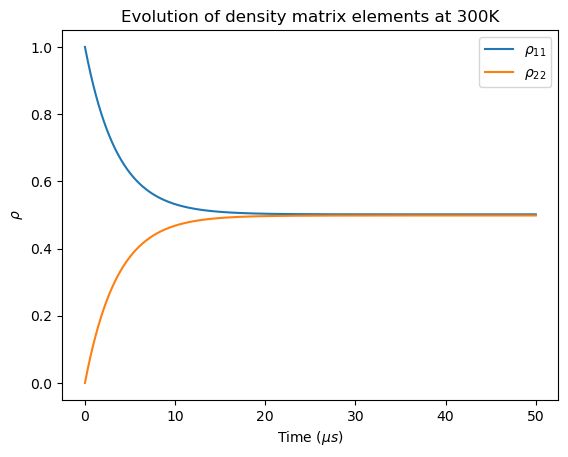

In [15]:
# Single Run
Temp = 300

tlist = np.linspace(1, 50e6, 2000) # in ps

specDensityX = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,0], T=Temp, sigma=2, shape='G')/hbar**2
specDensityY = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,1], T=Temp, sigma=2, shape='G')/hbar**2
specDensityZ = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=Temp, sigma=2, shape='G')/hbar**2

e_ops = []

aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]


rho0 = basis(2,0)*basis(2,0).dag()
results1 = brmesolve(-H/(hbar), rho0, tlist, a_ops=aops, e_ops=e_ops, progress_bar=True)

rho11_vals = np.array([results1.states[k].full()[0,0] for k in range(len(tlist))])
rho22_vals = np.array([results1.states[k].full()[1,1] for k in range(len(tlist))])

plt.figure()
plt.plot(tlist/1e6, np.abs(rho11_vals))
plt.plot(tlist/1e6, np.abs(rho22_vals))
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
plt.title("Evolution of density matrix elements at "+str(Temp)+"K")
plt.legend([r"$\rho_{11}$", r"$\rho_{22}$"])
plt.show()

In [16]:
kB = 8.617333262e-2 # meV/K, Boltzmann constant
w_th = kB*Temp/hbar # temperature defined as frequency
nth = n_thermal(energies[1]/hbar,w_th)
thermal_rho_11 = thermal_dm(2, nth, method='operator').full()[0].real[0]
thermal_rho_11

0.5005570207920286

In [17]:
# curve fitting to extract T1.
def t1_func_thermal(x,t1):
    kB = 8.6173e-2 # meV/K, Boltzmann constant
    w_th = kB*Temp/hbar # temperature defined as frequency
    nth = n_thermal(energies[1]/hbar,w_th)
    thermal_rho_11 = thermal_dm(2, nth, method='operator').full()[0].real[0]
    return (1-thermal_rho_11)*np.exp(-x/t1)+thermal_rho_11

def t1_func(x,t1, xinf):
    return (1-xinf)*np.exp(-x/t1)+xinf
    
def t1_func_classical(x,t1):
    return (1/2)*np.exp(-x/t1) + (1/2)

In [18]:
fthermal, df = curve_fit(t1_func_thermal, tlist/1e6, np.abs(rho11_vals))
fclassical, df = curve_fit(t1_func_classical, tlist/1e6, np.abs(rho11_vals))
f, df = curve_fit(t1_func, tlist/1e6, np.abs(rho11_vals))
f

array([3.56951316, 0.50168757])

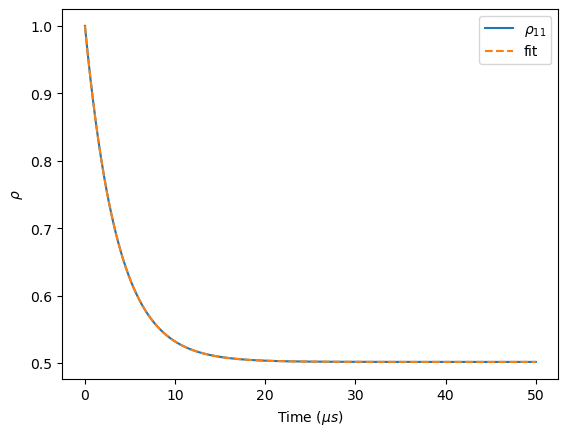

In [19]:
fit_thermal = np.array([t1_func_classical(k, fthermal)  for k in tlist/1e6])
fit_classical = np.array([t1_func_classical(k, fclassical)  for k in tlist/1e6])
fit_f = np.array([t1_func(k, f[0],f[1])  for k in tlist/1e6])
plt.figure()
plt.plot(tlist/1e6, np.abs(rho11_vals))
plt.plot(tlist/1e6, fit_f, '--')
#plt.plot(tlist/1e6, fit_thermal)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
#plt.title("Evolution of densitymatrix elements at "+str(Temp)+"K, T1 = "+str(f))
#plt.legend([r"$\rho_{11}$", r"fit $t_1 = $"+str(np.round(f,2)[0])+r"$\ \mu s$", r"fit_thermal $t_1 = $"+str(np.round(fthermal,2)[0])+r"$\ \mu s$"])
plt.legend([r"$\rho_{11}$", r"fit"])
plt.show()

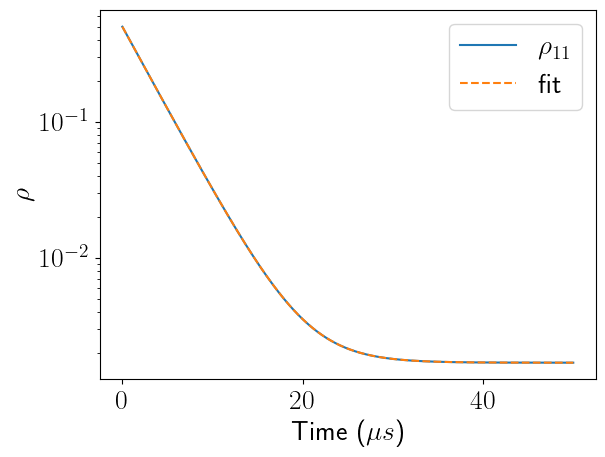

In [20]:
plt.rcParams['text.usetex'] = True 
plt.rcParams.update({'font.size': 20})
plt.figure()
plt.plot(tlist/1e6, np.abs(rho11_vals)-1/2)
plt.plot(tlist/1e6, fit_f-1/2, '--')
#plt.plot(tlist/1e6, fit_thermal)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
#plt.title("Evolution of densitymatrix elements at "+str(Temp)+"K, T1 = "+str(f))
#plt.legend([r"$\rho_{11}$", r"fit $t_1 = $"+str(np.round(f,2)[0])+r"$\ \mu s$", r"fit_thermal $t_1 = $"+str(np.round(fthermal,2)[0])+r"$\ \mu s$"])
plt.legend([r"$\rho_{11}$", r"fit"])
plt.yscale('log')
#plt.xscale('log')
plt.show()

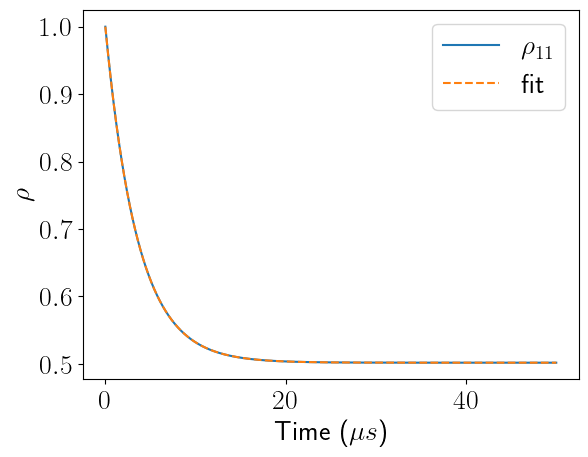

In [21]:
plt.rcParams['text.usetex'] = True 
plt.rcParams.update({'font.size': 20})
plt.figure()
plt.plot(tlist/1e6, np.abs(rho11_vals))
plt.plot(tlist/1e6, fit_f, '--')
#plt.plot(tlist/1e6, fit_thermal)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
#plt.title("Evolution of densitymatrix elements at "+str(Temp)+"K, T1 = "+str(f))
#plt.legend([r"$\rho_{11}$", r"fit $t_1 = $"+str(np.round(f,2)[0])+r"$\ \mu s$", r"fit_thermal $t_1 = $"+str(np.round(fthermal,2)[0])+r"$\ \mu s$"])
plt.legend([r"$\rho_{11}$", r"fit"])
#plt.yscale('log')
#plt.xscale('log')
plt.show()

## T2 Dynamics

In [22]:
tlist_t2 = np.linspace(1, 3e6, 10000) # in ps
rho0 = basis(2,0)*basis(2,1).dag()
rho0

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0. 1.]
 [0. 0.]]

In [23]:
Temp = 300
tlist_t2 = np.linspace(1, 3e6, 10000) # in ps
#rho0 = basis(2,0)*basis(2,1).dag()
rho0 = basis(2,0)*basis(2,1).dag() + basis(2,1)*basis(2,0).dag()
#rho0 = ket2dm((basis(2,0)+basis(2,1)).unit())

e_ops = []
specDensityX = lambda w : spectral_density_quantum(w, freqs=freq/hbar, coup=gcoupS[:,0]/hbar, T=Temp, sigma=2)
specDensityY = lambda w : spectral_density_quantum(w, freqs=freq/hbar, coup=gcoupS[:,1]/hbar, T=Temp, sigma=2)
specDensityZ = lambda w : spectral_density_quantum(w, freqs=freq/hbar, coup=gcoupS[:,2]/hbar, T=Temp, sigma=2)
aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    
results_k = brmesolve(H/(hbar), rho0, tlist_t2, a_ops=aops, e_ops=e_ops, progress_bar=True)

rho12 = np.array([results_k.states[j].full()[0,1] for j in range(len(tlist_t2))]) # 12 element of rho vs time 

10.0%. Run time:   1.58s. Est. time left: 00:00:00:14
20.0%. Run time:   3.14s. Est. time left: 00:00:00:12
30.0%. Run time:   4.71s. Est. time left: 00:00:00:10
40.0%. Run time:   6.26s. Est. time left: 00:00:00:09
50.0%. Run time:   7.83s. Est. time left: 00:00:00:07
60.0%. Run time:   9.39s. Est. time left: 00:00:00:06
70.0%. Run time:  10.96s. Est. time left: 00:00:00:04
80.0%. Run time:  12.52s. Est. time left: 00:00:00:03
90.0%. Run time:  14.09s. Est. time left: 00:00:00:01
Total run time:  15.65s


In [24]:
def t2_func(x,t2):
    return np.exp(-x/t2)#*(1/2)

In [25]:
t2, t2d = curve_fit(t2_func, tlist_t2/1e6, np.abs(rho12))
t2

array([0.89398651])

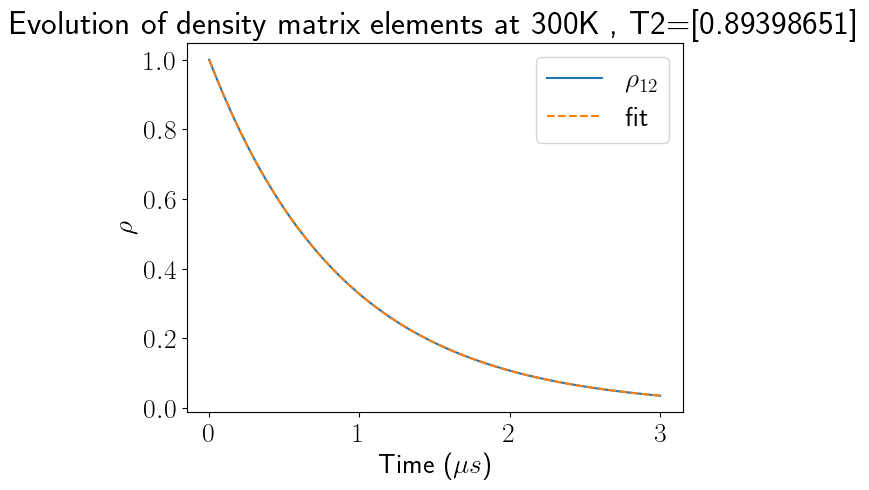

In [26]:

fit = np.array([t2_func(k,t2)  for k in tlist_t2/1e6])

plt.figure()
plt.plot(tlist_t2/1e6, np.abs(rho12))
plt.plot(tlist_t2/1e6, fit, '--')
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
plt.title("Evolution of density matrix elements at "+str(Temp)+"K , T2="+str(t2))
plt.legend([r"$\rho_{12}$", r"fit"])
plt.show()

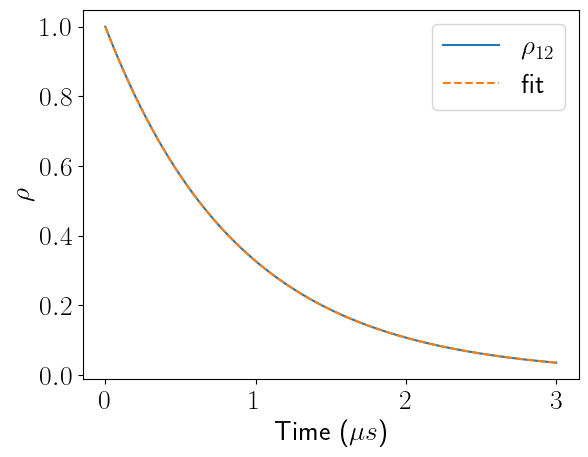

In [27]:
plt.figure()
plt.plot(tlist_t2/1e6, np.abs(rho12))
plt.plot(tlist_t2/1e6, fit, '--')
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
#plt.yscale('log')
#plt.title("Evolution of density matrix elements at "+str(Temp)+"K , T2="+str(t2))
plt.legend([r"$\rho_{12}$", r"fit"])
plt.show()

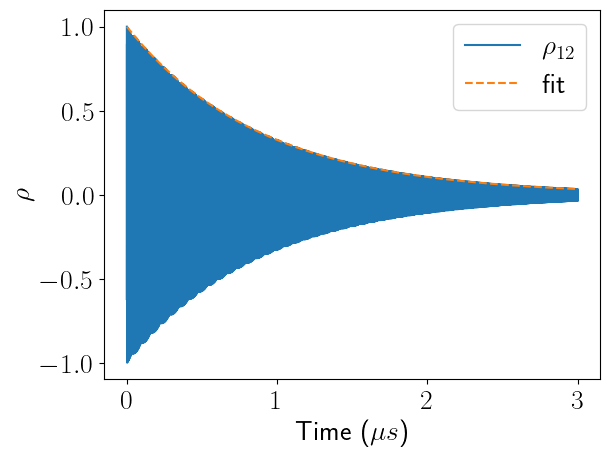

In [28]:
fit = np.array([t2_func(k,t2)  for k in tlist_t2/1e6])

plt.figure()
plt.plot(tlist_t2/1e6, np.real(rho12))
plt.plot(tlist_t2/1e6, fit, '--')
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
#plt.title("Evolution of density matrix elements at "+str(Temp)+"K , T2="+str(np.round(t2,3)))
plt.legend([r"$\rho_{12}$", r"fit "])
plt.show()

# SVD Mode projection

In [31]:
# performing SVD, 
gcoupTest = np.zeros((Np, 3),dtype=float) # defining a place holder for couplings
for k in range(Np):
    for j in range(3):
        gcoupTest[k,:] += alpha * dgx[k,:,j] * Bvector[j] * (1/2) * np.sqrt(hbar/(2*freq[k]/hbar))# only thing missing from here is Pauli matrix. Everything else is contained.
        #therefore, couplings will have units of energy as meV

U, L, Vdag = LA.svd(gcoupTest, full_matrices=False)  # note: the output of this funciton is U*S*Vh
print('\n singular values are ', L)

# Collecting columns of U that correspond to non-zero singular values
threshold = 1.e-12
Lnonzero = np.where(L > threshold)[0] # indices where the singular value is non-zero
Np_new = len(Lnonzero)  # total nonzero singular values

print('\n indices of non-zero singular values=', Lnonzero)
print('\n number of non-zeor singular values=', Np_new)

Usys = U[:,Lnonzero]
print('shape of Usys', np.shape(Usys))

# defining projection operators with the SVD Usys
A = Qobj(Usys)
#A = Qobj(gcoupS) # regular mode projection
P = A*(A.dag()*A).inv()*A.dag()
I = qeye(Np)
Q = I-P

print('shape of projection operator is ', np.shape(P))

Omega = Qobj(np.diag(freq**2)) # Hessian
Omega_s = P*Omega*P
Omega_b = Q*Omega*Q
val_s, vecs_s = Omega_s.eigenstates()
val_b, vecs_b = Omega_b.eigenstates()

Pnonzero = np.where(val_s > 1.e-9)[0]
Qnonzero = np.where(val_b > 1.e-9)[0]

# collecting nonzero-eigenvalues^0.5 of omega_s and omega_b
omega_s = np.real(np.sqrt(val_s[Pnonzero]))
omega_b = np.real(np.sqrt(val_b[Qnonzero]))
Ks = vecs_s[Pnonzero]
Kb = vecs_b[Qnonzero]

ns = len(Pnonzero)
nb = len(Qnonzero)
print('\n number of sys  phonon mode =', len(Pnonzero))
print('\n number of bath phonon mode =', len(Qnonzero))
print('With SVD mode projection, system modes cm-1 = ', omega_s/cm2mev)
print('With SVD mode projection, system modes meV = ', omega_s)
#print('system modes**2 cm-1 = ', omega_s**2/cm2mev)
#print('system modes**2 meV = ', omega_s**2)


 singular values are  [3.10975093e-05 1.93143530e-05 1.09395332e-05]

 indices of non-zero singular values= [0 1 2]

 number of non-zeor singular values= 3
shape of Usys (190, 3)
shape of projection operator is  (190, 190)

 number of sys  phonon mode = 3

 number of bath phonon mode = 187
With SVD mode projection, system modes cm-1 =  [170.05228774 352.20783648 533.98046135]
With SVD mode projection, system modes meV =  [21.08379664 43.6682064  66.20513965]


In [32]:
# Entropy of the projected system modes.import numpy as np
from scipy.stats import entropy

pk0 = np.squeeze(Ks[0].full().real)**2
pk1 = np.squeeze(Ks[1].full().real)**2
pk2 = np.squeeze(Ks[2].full().real)**2

print(entropy(pk0, base=np.e), entropy(pk1, base=np.e), entropy(pk2, base=np.e))

1.9636275846559728 3.224787498040543 3.4235869406112407


In [33]:
veclist = np.hstack((Ks,Kb))
gnewX = np.real(np.squeeze( (Qobj(gcoupS[:,0]).transform(veclist)).full()[:ns] ))
gnewY = np.real(np.squeeze( (Qobj(gcoupS[:,1]).transform(veclist)).full()[:ns] ))
gnewZ = np.real(np.squeeze( (Qobj(gcoupS[:,2]).transform(veclist)).full()[:ns] ))
# note: I have taken real parts only after inspecting that the imaginary parts are zeros.
print(gnewX, gnewY, gnewZ)

[ 8.82128840e-05  1.60675426e-04 -8.18859304e-05] [ 3.24822206e-05 -9.34571237e-05  3.95482160e-05] [6.11788430e-05 8.25845475e-05 1.59819524e-04]


In [34]:
L = P*Omega*Q + Q*Omega*P
newL = L.transform(veclist).tidyup(atol=1e-6)
newL

Quantum object: dims = [[190], [190]], shape = (190, 190), type = oper, isherm = True
Qobj data =
[[    0.             0.             0.         ...   549.88490675
  -2034.69847177  1522.66222051]
 [    0.             0.             0.         ...  1490.49011054
  -2239.24944268  2708.59015384]
 [    0.             0.             0.         ... -2236.99445614
   -622.16677135  -311.7531786 ]
 ...
 [  549.88490675  1490.49011054 -2236.99445614 ...     0.
      0.             0.        ]
 [-2034.69847177 -2239.24944268  -622.16677135 ...     0.
      0.             0.        ]
 [ 1522.66222051  2708.59015384  -311.7531786  ...     0.
      0.             0.        ]]

In [35]:
gamma_prime = np.real(newL.full()[:ns,ns:]) # the first index for gamma prime is for system phonon and second for bath phonon
Qobj(gamma_prime)

Quantum object: dims = [[3], [187]], shape = (3, 187), type = oper, isherm = False
Qobj data =
[[ 1.25245512e+00  2.01676996e-01 -7.55676323e+00  1.26396849e+01
  -1.06638983e+01 -4.07620893e+00  5.30714920e-01  2.28432553e+00
  -1.54530484e+01 -1.41383183e+01 -5.28414760e+01 -5.81306147e+00
  -6.43523092e+00  3.43067280e+00 -2.90683993e+00 -2.68904638e+01
   1.03843422e+01  4.22661752e+01 -2.57163980e+01 -6.45645892e+00
   6.89781642e+01 -1.81670128e+01  4.72324934e+01 -7.67600442e+01
   8.76288022e+00  1.98548325e+01 -9.37287173e+01 -1.17242136e+02
  -2.06376037e+00  5.46760703e+01 -3.91504433e+01 -1.47972821e+01
   1.17556153e+02 -4.49086182e+01  2.02239802e+02 -8.90743468e+01
   1.33032512e+02  1.93765289e+01 -2.74575291e+00 -8.22198882e+01
   6.06604327e+01 -2.07704634e+01 -1.23854026e+02 -3.72611166e+00
   4.28600784e+01 -2.94093707e+01 -6.34802073e+01  2.04166519e+02
   3.03149955e+01 -3.76336942e+01  1.44705364e+02  5.01948130e+01
  -2.33943854e+02  6.91401598e+00  1.62251591e+

## Analysis of projected modes

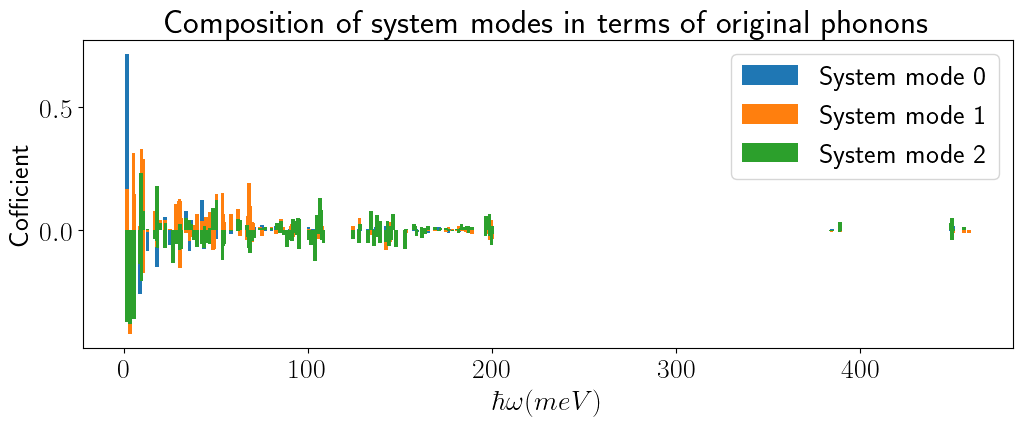

In [36]:
plt.figure(figsize=(12,4))
for i in range(len(Ks)):
    plt.bar(freq,np.squeeze(Ks[i].full().real), width=2)

plt.title(r"Composition of system modes in terms of original phonons")
plt.xlabel(r"$\hbar \omega (meV)$")
plt.ylabel(r"Cofficient")
#plt.yscale('log')
plt.legend(['System mode 0','System mode 1','System mode 2'])
plt.show()

In [37]:
def write_normalmode_xsf(coords, normal_modes, printlist, Usys=None):
    from periodictable import elements
    nats = len(coords)
    
    if Usys is not None:
        nmode, nsys = Usys.shape

    for k in printlist:
        if Usys is None:
            output = open('xsf/normalmode_%d.xsf'%k,'w')
            vec = normal_modes[k]
        else:
            output = open('xsf/proj_normalmode_%d.xsf'%k,'w')
            vec = np.zeros(3*nats)
            for i in range(nmode):
                vec += normal_modes[i] * Usys[i,k].real
        output.write("ATOMS\n")

        j = 0 
        for i in range(nats):
            symbol = coords[i][0]
            artnumber = elements.symbol(symbol).number
            vx = vec[j]
            vy = vec[j+1]
            vz = vec[j+2]
            j += 3
            output.write("{}  {}  {}  {}  {}  {}  {}\n".format(artnumber, coords[i][1],coords[i][2],coords[i][3], vx, vy, vz))
        output.close()

def write_normalmode_xsf_new(coords, normal_modes, proj_mode, k=0):
    from periodictable import elements
    nats = len(coords)
    nmode = len(normal_modes)
    output = open('xsf/proj_normalmode_%d.xsf'%k,'w')
    vec = np.zeros(3*nats)
    for i in range(nmode):
        vec += normal_modes[i] * proj_mode[i].real
    output.write("ATOMS\n")

    j = 0 
    for i in range(nats):
        symbol = coords[i][0]
        artnumber = elements.symbol(symbol).number
        vx = vec[j]
        vy = vec[j+1]
        vz = vec[j+2]
        j += 3
        output.write("{}  {}  {}  {}  {}  {}  {}\n".format(artnumber, coords[i][1],coords[i][2],coords[i][3], vx, vy, vz))
    output.close()

def write_normalmode_xsf_ORCA(coords, normal_modes, proj_mode, k=0, mass_weighted=True, scale_factor=1):
    from periodictable import elements
    nats = len(coords)
    nmode = len(normal_modes)
    output = open('xsf/proj_mode_column_%d.txt'%k,'w')
    vec = np.zeros(3*nats)
    for i in range(nmode):
        vec += normal_modes[i] * proj_mode[i].real
    
    j = 0 
    for i in range(nats):
        symbol = coords[i][0]
        if mass_weighted:
            atom_mass = elements.symbol(symbol).mass ## getting mass of each atom 
        else:
            atom_mass=1
        vx = vec[j]*np.sqrt(atom_mass) * scale_factor# mass weighting each displacement.
        vy = vec[j+1]*np.sqrt(atom_mass) * scale_factor
        vz = vec[j+2]*np.sqrt(atom_mass) * scale_factor
        j += 3
        output.write("{}\n{}\n{}\n".format(vx, vy, vz))
    output.close()

def get_modes(fname,fgeo,nmode=None):
    '''
    looks like fgeo is the optimized.xyz geometry file 
    and fname will be the spin_phonon_bare.dat file.
    '''
    # load coordinates
    logdata = open(fgeo).readlines()
    nats = int(logdata[0])
    coords = []
    for i in range(2,2+nats):
        xyz = logdata[i].split()
        #print(xyz)
        coords.append(xyz)

    logdata = open(fname).readlines()
    logdata = logdata[1:]

    normal_modes = np.zeros((nmode,3*nats))
    for i in range(nmode):
        j = i*5 + 1
        line = logdata[j]
        mode_vec = line.split()
        mode_vec = np.array(mode_vec)
        mode_vec = mode_vec.astype(float)
        normal_modes[i,:] = mode_vec
    
    return coords, normal_modes




fgeo = 'data files/optimized.xyz'
fname0 = 'data files/spin_phonon_bare.dat'
coords, normal_modes = get_modes(fname0,fgeo,nmode=198)
normal_modes = normal_modes[8:,:]
normal_modes.shape

(190, 198)

In [33]:
len(normal_modes)

190

In [34]:
#write_normalmode_xsf_ORCA(coords, normal_modes, np.squeeze(Ks[0].full().real), k=0, mass_weighted=False)
#write_normalmode_xsf_ORCA(coords, normal_modes, np.squeeze(Ks[1].full().real), k=1, mass_weighted=False)
#write_normalmode_xsf_ORCA(coords, normal_modes, np.squeeze(Ks[2].full().real), k=2, mass_weighted=False)

In [35]:
#freq/cm2mev

In [36]:
(0.0288558 **2 + 0.0132384**2 + 0.0149947**2)**0.5

0.035110588948207636

In [37]:
omega_s/cm2mev

array([170.05228774, 352.20783648, 533.98046135])

In [38]:
proj_mode_0 = np.squeeze(Ks[0].full().real)
proj_mode_1 = np.squeeze(Ks[1].full().real)
proj_mode_2 = np.squeeze(Ks[2].full().real)
proj_mode_0.shape

(190,)

## normal modes are 

In [39]:
#vec0 = np.zeros(3*nats)

#for i in range(len(normal_modes)):
#    vec += normal_modes[i] * proj_mode_0[i]

#j = 0
#for i in range(nats):
#    print(vec[j:j+3])
#    j += 3

## Spectral Densities of projected and bath modes

In [38]:
Temp = 300

In [39]:
def spectral_density_coupled_modes_classical(w, gcoup, gamma_coup, omega_s, omega_b, T=10, sigma=2):
    '''
    Generates spectral density of system modes affecting the spin system. The system modes are coupled to the bath
    modes. The units of gcoup, gamma_coup, omega_s and omega_b should all be energy.
    The units of spectral density are Eng^2 s. Therefore, division by hbar^2 must be done afterwards.
    '''
    kB = 8.6173e-2 # meV/K, Boltzmann constant
    #gamma = 2 # dampng meV
    S = 0

    for r in range(len(omega_s)):
        for rp in range(len(omega_s)):
            wr = omega_s[r]/hbar # freq of system phonon r
            wrp = omega_s[rp]/hbar # freq of system phonon rp
            cr = gcoup[r]/(np.sqrt(hbar/wr)) # energy / length
            crp = gcoup[rp]/(np.sqrt(hbar/wrp)) # energy / length

            for j in range(len(omega_b)):
                wj = omega_b[j]/hbar # freq of bath phonons
                gamma = sigma #0.2*wj # dampng rate = 20 % of mode frequency
                grj = gamma_coup[r,j]/( np.sqrt(hbar/wr)*np.sqrt(hbar/wj) ) # energy/length^2
                grpj = gamma_coup[rp, j]/( np.sqrt(hbar/wrp)*np.sqrt(hbar/wj) )# energy/length^2
                factor1 = (wj**2 - w**2)**2 + (gamma**2)*(w**2)
                factor2 = (wr**2-w**2)*(wrp**2-w**2)
                S += (cr*crp)*(grj*grpj)*(2*gamma*kB*T)/(factor1*factor2)
                #S += (2*gamma*kB*T)/(factor1*factor2)
    return S

In [40]:
gnewX, gnewY, gnewZ

(array([ 8.82128840e-05,  1.60675426e-04, -8.18859304e-05]),
 array([ 3.24822206e-05, -9.34571237e-05,  3.95482160e-05]),
 array([6.11788430e-05, 8.25845475e-05, 1.59819524e-04]))

In [41]:
x = np.linspace(0,freq[-1], 1000)
yX = [spectral_density_coupled_modes_classical(x/hbar,gnewX,gamma_prime,omega_s, omega_b, T=Temp)/hbar**2 for x in x]
yY = [spectral_density_coupled_modes_classical(x/hbar,gnewY,gamma_prime,omega_s, omega_b, T=Temp)/hbar**2 for x in x]
yZ = [spectral_density_coupled_modes_classical(x/hbar,gnewZ,gamma_prime,omega_s, omega_b, T=Temp)/hbar**2 for x in x]


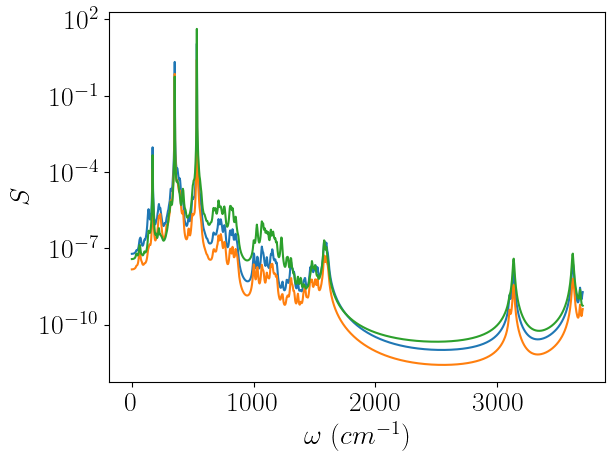

In [42]:
plt.figure()
plt.plot(x/cm2mev,yX)
plt.plot(x/cm2mev,yY)
plt.plot(x/cm2mev,yZ)
#plt.plot(omega_s/cm2mev, [spectral_density_coupled_modes_classical(x/hbar,gnewX,gamma_prime,omega_s, omega_b, Temp) for x in omega_s[:165]], 'x')
#plt.plot(omega_b[:165]/cm2mev, [spectral_density_coupled_modes_classical(x/hbar,gnewX,gamma_prime,omega_s, omega_b, Temp) for x in omega_b[:165]], '.')
plt.yscale('log')
plt.ylabel(r"$S$")
plt.xlabel(r"$\omega\ (cm^{-1})$")
#plt.legend([r"$\sigma_x$", r"$\sigma_y$", r"$\sigma_z$"])
plt.show()

In [45]:
gamma_prime[2,:].shape

(187,)

# Spin dyanmics with Mode Projection at 200 Tesla

In [46]:
print('projected mode freqs in meV are ', omega_s)

projected mode freqs in meV are  [21.08379664 43.6682064  66.20513965]


In [43]:
# Starting a system with spin and projected modes, isolated from bath modes
# the spin will be made resonant with the lowest energy system mode

Bfield = 200 # Tesla
print("applied magnetic field is ", Bfield, " Tesla")

Bvector = np.zeros(3)
Bvector[0] = 0
Bvector[1] = 0
Bvector[2] = Bfield


# Defining spin Hamiltonian
Hspin = None

# 1) Zeeman interaction
for i in range(3):
    for j in range(3):
        if Hspin is None:
            Hspin = alpha * gtensor[i][j] *(1/2)* sigma_vec[i] * Bvector[j] # notice this 1/2 here. its because i am using pauli matrices 
        else:
            Hspin += alpha * gtensor[i][j] *(1/2)* sigma_vec[i] * Bvector[j]# instead of spin 1/2 matrices 

print('Spin zeeman hamiltonian')
#H.tidyup()
Hspin

applied magnetic field is  200  Tesla
Spin zeeman hamiltonian


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 11.52007767+0.j           0.01276522+0.00512334j]
 [  0.01276522-0.00512334j -11.52007767+0.j        ]]

In [44]:
energies, estates  = Hspin.eigenstates() # the eigenstates are in acending order, the -ve reintroduces the decending order
energies, estates

(array([-11.52008588,  11.52008588]),
 array([Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
        Qobj data =
        [[-5.96999835e-04+0.j        ]
         [ 9.28043463e-01-0.37247144j]]                              ,
        Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
        Qobj data =
        [[-9.99999822e-01+0.j        ]
         [-5.54041893e-04+0.00022237j]]                              ],
       dtype=object))

In [45]:
Hspin = Hspin.transform(estates)
Hspin

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[-11.52008588   0.        ]
 [  0.          11.52008588]]

In [46]:
print('spin transition frequency in meV')
energies[1]-energies[0]

spin transition frequency in meV


23.040171765750117

In [47]:
# phonon Hamiltonian
nph = 2
a = destroy(nph)
Hp = tensor(qeye(2), omega_s[0]*a.dag()*a, qeye(nph), qeye(nph))
Hp += tensor(qeye(2), qeye(nph), omega_s[1]*a.dag()*a, qeye(nph))
Hp += tensor(qeye(2), qeye(nph), qeye(nph), omega_s[2]*a.dag()*a)
Hp

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [  0.          66.20513965   0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.          43.6682064    0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.         109.87334604   0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.          21.08379664
    0.           0.           0.           0.      

## performing mode projection at 200 T

In [48]:
Np = len(freq)
gcoupS = np.zeros((Np, 3),dtype=float) # defining a place holder for couplings
for k in range(Np):
    for j in range(3):
        gcoupS[k,:] += alpha * dgx[k,:,j] * Bvector[j] * (1/2) # only thing missing from here is Pauli matrix. Everything else is contained.
        #therefore, couplings will have units of energy as meV

# NOTE: this coupling also has the harmonic bath displacement operator contained in it. therefore, it has units of meV.
print('First 5 new couplings \n', gcoupS[:5])
print('these couplings are for the Pauli X, Y, Z operators.')

First 5 new couplings 
 [[ 0.01098556  0.00050678  0.00197022]
 [-0.00582464  0.0016868  -0.00963291]
 [ 0.00125344 -0.0059917  -0.00460528]
 [-0.00085962 -0.00481263 -0.00841203]
 [-0.00435588  0.00196967 -0.00646957]]
these couplings are for the Pauli X, Y, Z operators.


In [49]:
# performing SVD, 
gcoupTest = np.zeros((Np, 3),dtype=float) # defining a place holder for couplings
for k in range(Np):
    for j in range(3):
        gcoupTest[k,:] += alpha * dgx[k,:,j] * Bvector[j] * (1/2) * np.sqrt(hbar/(2*freq[k]/hbar))# only thing missing from here is Pauli matrix. Everything else is contained.
        #therefore, couplings will have units of energy as meV

U, L, Vdag = LA.svd(gcoupTest, full_matrices=False)  # note: the output of this funciton is U*S*Vh
print('\n singular values are ', L)

# Collecting columns of U that correspond to non-zero singular values
threshold = 1.e-12
Lnonzero = np.where(L > threshold)[0] # indices where the singular value is non-zero
Np_new = len(Lnonzero)  # total nonzero singular values

print('\n indices of non-zero singular values=', Lnonzero)
print('\n number of non-zeor singular values=', Np_new)

Usys = U[:,Lnonzero]
print('shape of Usys', np.shape(Usys))

# defining projection operators with the SVD Usys
A = Qobj(Usys)
#A = Qobj(gcoupS) # regular mode projection
P = A*(A.dag()*A).inv()*A.dag()
I = qeye(Np)
Q = I-P

print('shape of projection operator is ', np.shape(P))

Omega = Qobj(np.diag(freq**2)) # Hessian
Omega_s = P*Omega*P
Omega_b = Q*Omega*Q
val_s, vecs_s = Omega_s.eigenstates()
val_b, vecs_b = Omega_b.eigenstates()

Pnonzero = np.where(val_s > 1.e-9)[0]
Qnonzero = np.where(val_b > 1.e-9)[0]

# collecting nonzero-eigenvalues^0.5 of omega_s and omega_b
omega_s = np.real(np.sqrt(val_s[Pnonzero]))
omega_b = np.real(np.sqrt(val_b[Qnonzero]))
Ks = vecs_s[Pnonzero]
Kb = vecs_b[Qnonzero]

ns = len(Pnonzero)
nb = len(Qnonzero)
print('\n number of sys  phonon mode =', len(Pnonzero))
print('\n number of bath phonon mode =', len(Qnonzero))
print('With SVD mode projection, system modes cm-1 = ', omega_s/cm2mev)
print('With SVD mode projection, system modes meV = ', omega_s)
#print('system modes**2 cm-1 = ', omega_s**2/cm2mev)
#print('system modes**2 meV = ', omega_s**2)


 singular values are  [0.0062195  0.00386287 0.00218791]

 indices of non-zero singular values= [0 1 2]

 number of non-zeor singular values= 3
shape of Usys (190, 3)
shape of projection operator is  (190, 190)

 number of sys  phonon mode = 3

 number of bath phonon mode = 187
With SVD mode projection, system modes cm-1 =  [170.05228774 352.20783648 533.98046135]
With SVD mode projection, system modes meV =  [21.08379664 43.6682064  66.20513965]


In [50]:
veclist = np.hstack((Ks,Kb))
gnewX = np.real(np.squeeze( (Qobj(gcoupS[:,0]).transform(veclist)).full()[:ns] ))
gnewY = np.real(np.squeeze( (Qobj(gcoupS[:,1]).transform(veclist)).full()[:ns] ))
gnewZ = np.real(np.squeeze( (Qobj(gcoupS[:,2]).transform(veclist)).full()[:ns] ))
# note: I have taken real parts only after inspecting that the imaginary parts are zeros.
print(gnewX, gnewY, gnewZ)

[ 0.01764258  0.03213509 -0.01637719] [ 0.00649644 -0.01869142  0.00790964] [0.01223577 0.01651691 0.0319639 ]


In [51]:
L = P*Omega*Q + Q*Omega*P
newL = L.transform(veclist).tidyup(atol=1e-6)
newL

Quantum object: dims = [[190], [190]], shape = (190, 190), type = oper, isherm = True
Qobj data =
[[    0.             0.             0.         ...   549.88490675
  -2034.69847177  1522.66222051]
 [    0.             0.             0.         ...  1490.49011054
  -2239.24944268  2708.59015384]
 [    0.             0.             0.         ... -2236.99445614
   -622.16677135  -311.7531786 ]
 ...
 [  549.88490675  1490.49011054 -2236.99445614 ...     0.
      0.             0.        ]
 [-2034.69847177 -2239.24944268  -622.16677135 ...     0.
      0.             0.        ]
 [ 1522.66222051  2708.59015384  -311.7531786  ...     0.
      0.             0.        ]]

In [52]:
gamma_prime = np.real(newL.full()[:ns,ns:]) # the first index for gamma prime is for system phonon and second for bath phonon
Qobj(gamma_prime)

Quantum object: dims = [[3], [187]], shape = (3, 187), type = oper, isherm = False
Qobj data =
[[ 1.25245512e+00  2.01676996e-01 -7.55676323e+00  1.26396849e+01
   1.06638983e+01 -4.07620893e+00 -5.30714920e-01 -2.28432553e+00
  -1.54530484e+01 -1.41383183e+01 -5.28414760e+01 -5.81306147e+00
  -6.43523092e+00  3.43067280e+00 -2.90683993e+00 -2.68904638e+01
   1.03843422e+01  4.22661752e+01 -2.57163980e+01 -6.45645892e+00
   6.89781642e+01 -1.81670128e+01  4.72324934e+01 -7.67600442e+01
   8.76288022e+00  1.98548325e+01 -9.37287173e+01 -1.17242136e+02
  -2.06376037e+00  5.46760703e+01 -3.91504433e+01 -1.47972821e+01
   1.17556153e+02 -4.49086182e+01  2.02239802e+02  8.90743468e+01
  -1.33032512e+02 -1.93765289e+01 -2.74575291e+00 -8.22198882e+01
   6.06604327e+01 -2.07704634e+01 -1.23854026e+02 -3.72611166e+00
   4.28600784e+01 -2.94093707e+01 -6.34802073e+01  2.04166519e+02
   3.03149955e+01 -3.76336942e+01 -1.44705364e+02  5.01948130e+01
  -2.33943854e+02  6.91401598e+00  1.62251591e+

## Back to constructing Hamiltonian

In [53]:
# spin-phonon coupling Hamiltonian
cx = tensor(sigmax(), gnewX[0]*(a.dag()+a)/np.sqrt(2), qeye(nph), qeye(nph)) 
cx += tensor(sigmax(), qeye(nph), gnewX[1]*(a.dag()+a)/np.sqrt(2), qeye(nph)) 
cx += tensor(sigmax(), qeye(nph), qeye(nph), gnewX[2]*(a.dag()+a)/np.sqrt(2)) 

cy = tensor(sigmay(), gnewY[0]*(a.dag()+a)/np.sqrt(2), qeye(nph), qeye(nph)) 
cy += tensor(sigmay(), qeye(nph), gnewY[1]*(a.dag()+a)/np.sqrt(2), qeye(nph)) 
cy += tensor(sigmay(), qeye(nph), qeye(nph), gnewY[2]*(a.dag()+a)/np.sqrt(2)) 

cz = tensor(sigmaz(), gnewZ[0]*(a.dag()+a)/np.sqrt(2), qeye(nph), qeye(nph)) 
cz += tensor(sigmaz(), qeye(nph), gnewZ[1]*(a.dag()+a)/np.sqrt(2), qeye(nph)) 
cz += tensor(sigmaz(), qeye(nph), qeye(nph), gnewZ[2]*(a.dag()+a)/np.sqrt(2)) 


Hint = cx + cy + cz
Hint

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[ 0.        +0.j          0.02260189+0.j          0.01167922+0.j
   0.        +0.j          0.00865199+0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
  -0.01158042-0.00559296j  0.02272294+0.01321683j  0.        +0.j
   0.01247519-0.00459368j  0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.02260189+0.j          0.        +0.j          0.        +0.j
   0.01167922+0.j          0.        +0.j          0.00865199+0.j
   0.        +0.j          0.        +0.j         -0.01158042-0.00559296j
   0.        +0.j          0.        +0.j          0.02272294+0.01321683j
   0.        +0.j          0.01247519-0.00459368j  0.        +0.j
   0.        +0.j        ]
 [ 0.01167922+0.j          0.        +0.j          0.        +0.j
   0.02260189+0.j          0.        +0.j          0.        +0.j
   0.00865199+0.j          0

In [54]:
Htotal = tensor(Hspin, qeye(nph), qeye(nph), qeye(nph))
Htotal += Hp
Htotal += 1*Hint
Htotal

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[-1.15200859e+01+0.j          2.26018939e-02+0.j
   1.16792187e-02+0.j          0.00000000e+00+0.j
   8.65199495e-03+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j         -1.15804193e-02-0.00559296j
   2.27229366e-02+0.01321683j  0.00000000e+00+0.j
   1.24751857e-02-0.00459368j  0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j        ]
 [ 2.26018939e-02+0.j          5.46850538e+01+0.j
   0.00000000e+00+0.j          1.16792187e-02+0.j
   0.00000000e+00+0.j          8.65199495e-03+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
  -1.15804193e-02-0.00559296j  0.00000000e+00+0.j
   0.00000000e+00+0.j          2.27229366e-02+0.01321683j
   0.00000000e+00+0.j          1.24751857e-02-0.00459368j
   0.00000000e+00+0.j          0.00000000e+00+0.j        ]
 [ 1.16792187e-02+0.j          0.00000000e+00+0.

In [55]:
n_th = 10
cops = [tensor(qeye(2), n_th*(a.dag()+a), qeye(nph), qeye(nph)),
         tensor(qeye(2), qeye(nph), n_th*(a.dag()+a), qeye(nph)),
         tensor(qeye(2), qeye(nph), qeye(nph), n_th*(a.dag()+a))]

In [81]:
tlist = np.linspace(0, 1, 1000)
psi0 = tensor(basis(2,1), basis(2,0), basis(2,0), basis(2,0))
results200 = mesolve(Htotal/hbar, psi0, tlist, c_ops=cops, e_ops=[], progress_bar = True)

10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.02s. Est. time left: 00:00:00:00
30.0%. Run time:   0.02s. Est. time left: 00:00:00:00
40.0%. Run time:   0.03s. Est. time left: 00:00:00:00
50.0%. Run time:   0.04s. Est. time left: 00:00:00:00
60.0%. Run time:   0.04s. Est. time left: 00:00:00:00
70.0%. Run time:   0.05s. Est. time left: 00:00:00:00
80.0%. Run time:   0.05s. Est. time left: 00:00:00:00
90.0%. Run time:   0.06s. Est. time left: 00:00:00:00
Total run time:   0.07s


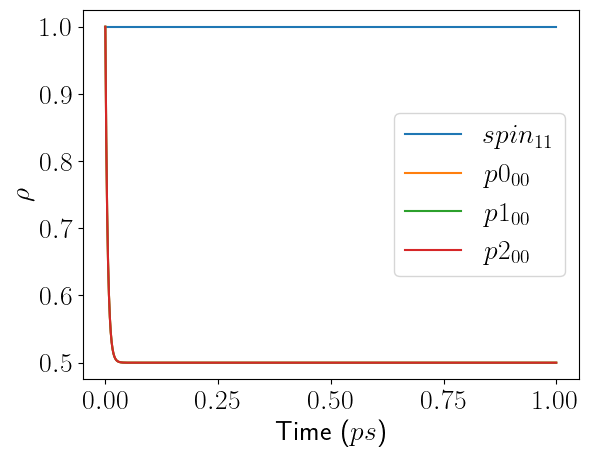

In [83]:
rho_spin_00 = tensor(basis(2,0)*basis(2,0).dag(), qeye(nph), qeye(nph), qeye(nph))
rho_spin_11 = tensor(basis(2,1)*basis(2,1).dag(), qeye(nph), qeye(nph), qeye(nph))
rho_p0_00 = tensor(qeye(2), basis(2,0)*basis(2,0).dag(), qeye(nph), qeye(nph))
rho_p0_11 = tensor(qeye(2), basis(2,1)*basis(2,1).dag(), qeye(nph), qeye(nph))
rho_p1_00 = tensor(qeye(2), qeye(nph), basis(2,0)*basis(2,0).dag(), qeye(nph))
rho_p1_11 = tensor(qeye(2), qeye(nph), basis(2,1)*basis(2,1).dag(), qeye(nph))
rho_p2_00 = tensor(qeye(2), qeye(nph), qeye(nph), basis(2,0)*basis(2,0).dag())
rho_p2_11 = tensor(qeye(2), qeye(nph), qeye(nph), basis(2,1)*basis(2,1).dag())


#rho11_vals = np.array([results200.states[k].full()[0,0] for k in range(len(tlist))])
#rho22_vals = np.array([results200.states[k].full()[1,1] for k in range(len(tlist))])

plt.figure()
#plt.plot(tlist, np.real(expect(rho_spin_00,results200.states)))
plt.plot(tlist, np.real(expect(rho_spin_11,results200.states)))
plt.plot(tlist, np.real(expect(rho_p0_00,results200.states)))
#plt.plot(tlist, np.real(expect(rho_p0_11,results200.states)))
plt.plot(tlist, np.real(expect(rho_p1_00,results200.states)))
plt.plot(tlist, np.real(expect(rho_p2_00,results200.states)))

plt.xlabel(r"Time ($ps$)")
plt.ylabel(r"$\rho$")
#plt.title("Evolution of density matrix elements at in isolated systemK")
#plt.legend([r"$spin_{00}$", r"$spin_{11}$", r"$p0_{00}$", r"$p0_{11}$"])
plt.legend([r"$spin_{11}$", r"$p0_{00}$", r"$p1_{00}$", r"$p2_{00}$"])
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_major_formatter'

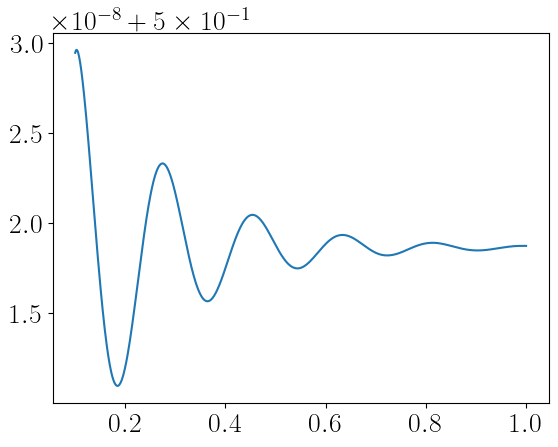

In [84]:
lim1=100
plt.figure()
plt.plot(tlist[lim1:], np.real(expect(rho_p0_11,results200.states))[lim1:])
#plt.plot(tlist[lim1:], np.real(expect(rho_p1_00,results200.states))[lim1:])
#plt.plot(tlist[lim1:], np.real(expect(rho_p2_00,results200.states))[lim1:])
plt.set_major_formatter(FormatStrFormatter('%.3f'))
plt.yscale('log')
plt.xlabel(r"Time ($ps$)")
plt.ylabel(r"$\rho$")
plt.legend([r"$p0_{11}$", r"$p1_{00}$", r"$p2_{00}$"])
plt.show()

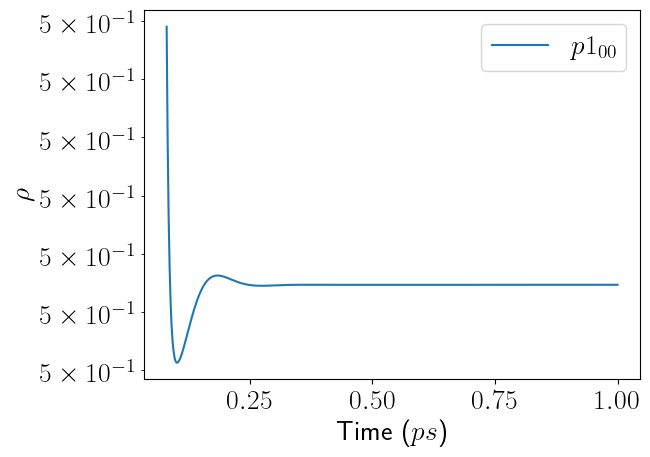

In [93]:
lim1=80
plt.figure()
#plt.plot(tlist[lim1:], np.real(expect(rho_p0_11,results200.states))[lim1:])
plt.plot(tlist[lim1:], np.real(expect(rho_p1_00,results200.states))[lim1:])
#plt.plot(tlist[lim1:], np.real(expect(rho_p2_00,results200.states))[lim1:])
plt.yscale('log')
plt.xlabel(r"Time ($ps$)")
plt.ylabel(r"$\rho$")
#plt.legend([r"$p0_{11}$", r"$p1_{00}$", r"$p2_{00}$"])
plt.legend([r"$p1_{00}$"])
#plt.legend([r"$p2_{00}$"])
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_major_formatter'

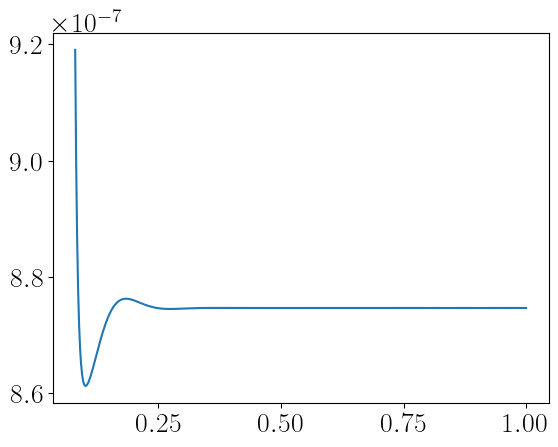

In [103]:
lim1=80
plt.figure()
#plt.plot(tlist[lim1:], np.real(expect(rho_p0_00,results200.states))[lim1:]-0.5)
#plt.plot(tlist[lim1:], np.real(expect(rho_p1_00,results200.states))[lim1:]-0.499999)
#plt.plot(tlist[lim1:], np.real(expect(rho_p2_00,results200.states))[lim1:])
plt.set_major_formatter(FormatStrFormatter('%.3f'))
plt.yscale('log')
plt.xlabel(r"Time ($ps$)")
plt.ylabel(r"$\rho$")
#plt.legend([r"$p0_{11}$", r"$p1_{00}$", r"$p2_{00}$"])
plt.legend([r"$p1_{00}$"])
#plt.legend([r"$p2_{00}$"])
plt.show()

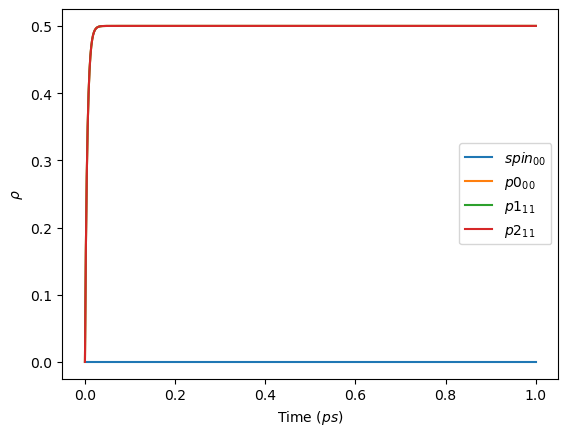

In [74]:
plt.figure()
plt.plot(tlist, np.real(expect(rho_spin_00,results200.states)))
#plt.plot(tlist, np.real(expect(rho_spin_11,results200.states)))
plt.plot(tlist, np.real(expect(rho_p0_00,results200.states)))
##plt.plot(tlist, np.real(expect(rho_p0_11,results200.states)))
##plt.plot(tlist, np.real(expect(rho_p1_00,results200.states)))
plt.plot(tlist, np.real(expect(rho_p1_11,results200.states)))
#plt.plot(tlist, np.real(expect(rho_p2_00,results200.states)))
plt.plot(tlist, np.real(expect(rho_p2_11,results200.states)))

plt.xlabel(r"Time ($ps$)")
plt.ylabel(r"$\rho$")
#plt.title("Evolution of density matrix elements in isolated system")
plt.legend([r"$spin_{00}$", r"$p0_{00}$", r"$p1_{11}$", r"$p2_{11}$"])
#plt.legend([r"$spin_{11}$", r"$p0_{11}$", r"$1+p1_{11}$", r"$1+p2_{11}$"])
plt.show()

# Single phonon mode 0 with spin

In [67]:
tlist = np.linspace(0, 1, 1000)
psi0 = tensor(basis(2,1), basis(2,1))
results = mesolve((Hdummy+Hint)/hbar, psi0, tlist, c_ops=[], e_ops=[])

Text(0, 0.5, 'population')

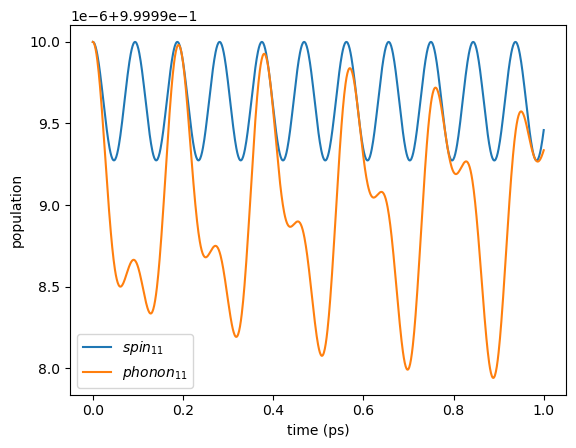

In [68]:
spin00 = tensor(basis(2,0)*basis(2,0).dag(), qeye(2))
spin11 = tensor(basis(2,1)*basis(2,1).dag(), qeye(2))
pho00 = tensor(qeye(2), basis(2,0)*basis(2,0).dag())
pho11 = tensor(qeye(2), basis(2,1)*basis(2,1).dag())
plt.figure()
plt.plot(tlist, expect(spin11, results.states))
plt.plot(tlist, expect(pho11, results.states))
plt.legend([r"$spin_{11}$", r"$phonon_{11}$"])
plt.xlabel("time (ps)")
plt.ylabel("population")

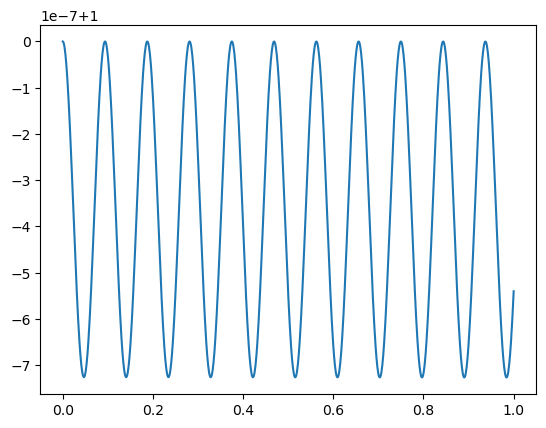

In [69]:
plt.figure()
plt.plot(tlist, expect(spin11, results.states))
#plt.plot(tlist, expect(pho11, results.states))
plt.show()

In [74]:
kappa = 0.5  # coupling to oscillator

# collapse operators
c_op_list = []
n_th_a = 2  # temperature with average of 2 excitations
rate = kappa * (n_th_a)
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * a)  # decay operators
rate = kappa * (n_th_a)
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * a.dag())  # excitation operators


In [75]:
c_op_list = [1*(a.dag()+a)]

In [76]:
tlist = np.linspace(0, 10, 1000)
results = mesolve(a.dag()*a, basis(2,1), tlist, c_ops = c_op_list, e_ops=[])

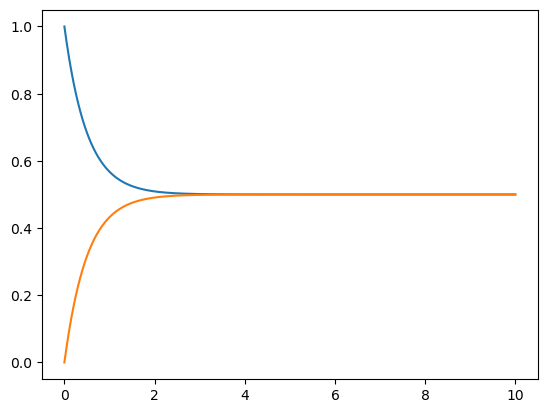

In [77]:
plt.figure()
plt.plot(tlist, expect(basis(2,1)*basis(2,1).dag(), results.states))
plt.plot(tlist, expect(basis(2,0)*basis(2,0).dag(), results.states))

# T1 extraction and lindblad dynamics of projected modes

10.0%. Run time:   0.06s. Est. time left: 00:00:00:00
20.0%. Run time:   0.12s. Est. time left: 00:00:00:00
30.0%. Run time:   0.19s. Est. time left: 00:00:00:00
40.0%. Run time:   0.25s. Est. time left: 00:00:00:00
50.0%. Run time:   0.31s. Est. time left: 00:00:00:00
60.0%. Run time:   0.38s. Est. time left: 00:00:00:00
70.0%. Run time:   0.44s. Est. time left: 00:00:00:00
80.0%. Run time:   0.51s. Est. time left: 00:00:00:00
90.0%. Run time:   0.57s. Est. time left: 00:00:00:00
Total run time:   0.63s


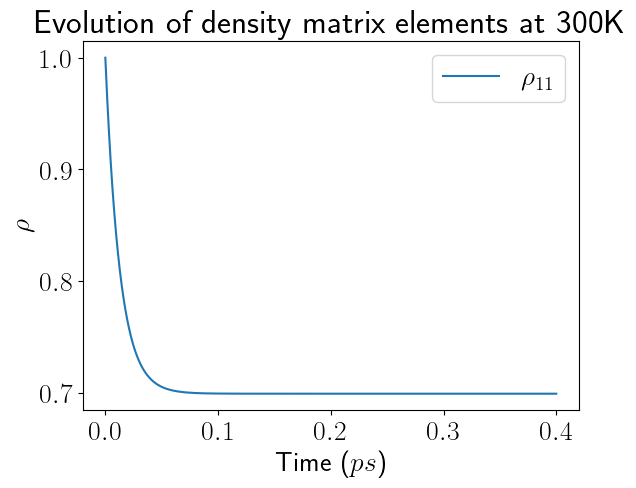

In [82]:
mode = 0
Hp = omega_s[mode]*destroy(2).dag()*destroy(2)
x = np.sqrt(hbar/(2*omega_s[mode]))*(destroy(2)+destroy(2).dag()) # displacement operator for the mode0

# Single Run
Temp = 300

tlist = np.linspace(0, 40e-2, 1000) # in ps

specDensityBathModes = lambda w : spectral_density_quantum(w, freqs=omega_b, coup=gamma_prime[mode,:], T=Temp, sigma=2, shape='G')/hbar**2

e_ops = []

aops = [[x,specDensityBathModes]]


rho0 = basis(2,0)*basis(2,0).dag()
results1 = brmesolve(Hp/(hbar), rho0, tlist, a_ops=aops, e_ops=e_ops, progress_bar=True)

rho11_vals = np.array([results1.states[k].full()[0,0] for k in range(len(tlist))])
rho22_vals = np.array([results1.states[k].full()[1,1] for k in range(len(tlist))])
rho12_vals = np.array([results1.states[k].full()[0,1] for k in range(len(tlist))])

plt.figure()
plt.plot(tlist, np.abs(rho11_vals))
#plt.plot(tlist, np.abs(rho22_vals))
##plt.yscale('log')
plt.xlabel(r"Time ($ps$)")
plt.ylabel(r"$\rho$")
plt.title("Evolution of density matrix elements at "+str(Temp)+"K")
#plt.legend([r"$\rho_{11}$", r"$\rho_{22}$"])
#plt.legend([r"$\rho_{12}$"])
plt.legend([r"$\rho_{11}$", r"fit $T_1 = $"+str(1000*np.round(f,5)[0])+r"$\ fs$", r"fit_thermal $T_1 = $"+str(np.round(fthermal,5)[0])+r"$\ p s$"])

plt.show()


the T1 time in ps 0.012837942088339752


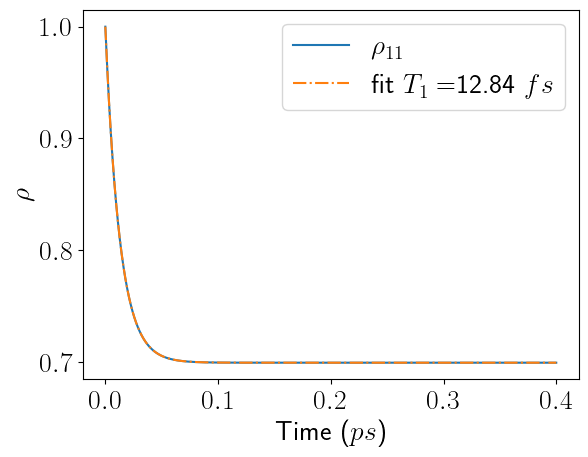

In [83]:
f, df = curve_fit(t1_func, tlist, np.abs(rho11_vals))
fit_f = np.array([t1_func(k, f[0],f[1])  for k in tlist])
plt.figure()
plt.plot(tlist, np.abs(rho11_vals))
plt.plot(tlist, fit_f, '-.')
plt.xlabel(r"Time ($ps$)")
plt.ylabel(r"$\rho$")
plt.legend([r"$\rho_{11}$", r"fit $T_1 = $"+str(1000*np.round(f,5)[0])+r"$\ fs$", r"fit_thermal $T_1 = $"+str(np.round(1000*fthermal,5)[0])+r"$\ fs$"])
print('the T1 time in ps', f[0])

In [84]:
# t1 times for the phonons
t1p = [0.012837945681530277, 0.0005711617135254505, 0.00019536814504390486]

10.0%. Run time:   0.06s. Est. time left: 00:00:00:00
20.0%. Run time:   0.12s. Est. time left: 00:00:00:00
30.0%. Run time:   0.18s. Est. time left: 00:00:00:00
40.0%. Run time:   0.25s. Est. time left: 00:00:00:00
50.0%. Run time:   0.31s. Est. time left: 00:00:00:00
60.0%. Run time:   0.38s. Est. time left: 00:00:00:00
70.0%. Run time:   0.44s. Est. time left: 00:00:00:00
80.0%. Run time:   0.51s. Est. time left: 00:00:00:00
90.0%. Run time:   0.57s. Est. time left: 00:00:00:00
Total run time:   0.63s


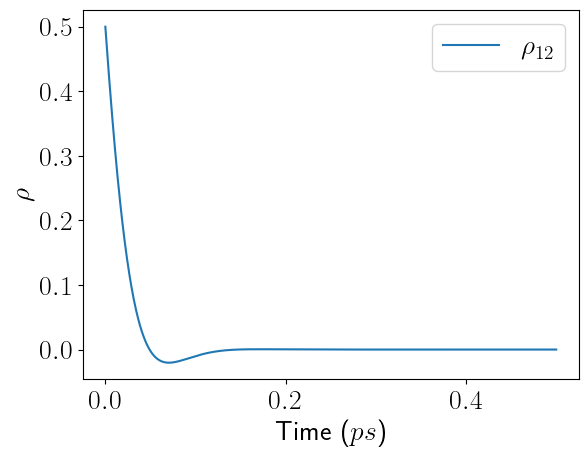

In [79]:
## T2 time 

mode = 0
Hp = omega_s[mode]*destroy(2).dag()*destroy(2)
x = np.sqrt(hbar/(2*omega_s[mode]))*(destroy(2)+destroy(2).dag()) # displacement operator for the mode0

# Single Run
Temp = 300

tlist = np.linspace(0, 5e-1, 1000) # in ps

specDensityBathModes = lambda w : spectral_density_quantum(w, freqs=omega_b, coup=gamma_prime[mode,:], T=Temp, sigma=2, shape='G')/hbar**2

e_ops = []

aops = [[x,specDensityBathModes]]


rho0 = ket2dm((basis(2,0)+basis(2,1)).unit())
results1 = brmesolve(Hp/(hbar), rho0, tlist, a_ops=aops, e_ops=e_ops, progress_bar=True)

rho11_vals = np.array([results1.states[k].full()[0,0] for k in range(len(tlist))])
rho22_vals = np.array([results1.states[k].full()[1,1] for k in range(len(tlist))])
rho12_vals = np.array([results1.states[k].full()[0,1] for k in range(len(tlist))])

plt.rcParams['text.usetex'] = True 
plt.rcParams.update({'font.size': 20})
plt.figure()
#plt.plot(tlist, np.abs(rho11_vals))
#plt.plot(tlist, np.abs(rho22_vals))
plt.plot(tlist, np.real(rho12_vals))
##plt.yscale('log')
plt.xlabel(r"Time ($ps$)")
plt.ylabel(r"$\rho$")
#plt.title("Evolution of density matrix elements at "+str(Temp)+"K")
#plt.legend([r"$\rho_{11}$", r"$\rho_{22}$"])
plt.legend([r"$\rho_{12}$"])
#plt.legend([r"$\rho_{11}$", r"fit $T_1 = $"+str(1000*np.round(f,5)[0])+r"$\ fs$", r"fit_thermal $T_1 = $"+str(np.round(fthermal,5)[0])+r"$\ p s$"])

plt.show()


### Thermalizing normal mode

10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:   0.01s. Est. time left: 00:00:00:00
30.0%. Run time:   0.01s. Est. time left: 00:00:00:00
40.0%. Run time:   0.01s. Est. time left: 00:00:00:00
50.0%. Run time:   0.01s. Est. time left: 00:00:00:00
60.0%. Run time:   0.02s. Est. time left: 00:00:00:00
70.0%. Run time:   0.02s. Est. time left: 00:00:00:00
80.0%. Run time:   0.02s. Est. time left: 00:00:00:00
90.0%. Run time:   0.02s. Est. time left: 00:00:00:00
Total run time:   0.03s


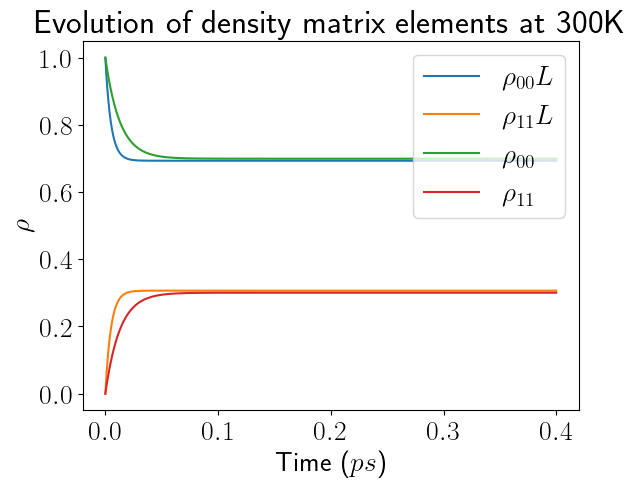

In [85]:
e_ops = []
#cops = [c0*x]
n_th = n_thermal(omega_s[mode], kB*Temp)
cops = [np.sqrt((1/t1p[mode]) * (1+n_th)) * destroy(2), np.sqrt((1/t1p[mode]) * (n_th)) * destroy(2).dag()]

rho0 = basis(2,0)*basis(2,0).dag()
results2 = mesolve(Hp/(hbar), rho0, tlist, c_ops=cops, e_ops=e_ops, progress_bar=True)

rho11_vals_L = np.array([results2.states[k].full()[0,0] for k in range(len(tlist))])
rho22_vals_L = np.array([results2.states[k].full()[1,1] for k in range(len(tlist))])

plt.figure()
plt.plot(tlist, np.abs(rho11_vals_L))
plt.plot(tlist, np.abs(rho22_vals_L))
plt.plot(tlist, np.abs(rho11_vals))
plt.plot(tlist, np.abs(rho22_vals))
plt.xlabel(r"Time ($ps$)")
plt.ylabel(r"$\rho$")
plt.title("Evolution of density matrix elements at "+str(Temp)+"K")
plt.legend([r"$\rho_{00}L$", r"$\rho_{11}L$", r"$\rho_{00}$", r"$\rho_{11}$"])
plt.show()

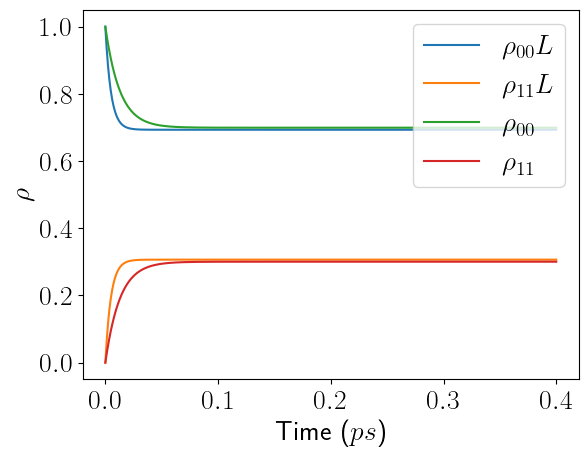

In [86]:
plt.figure()
plt.plot(tlist, np.abs(rho11_vals_L))
plt.plot(tlist, np.abs(rho22_vals_L))
plt.plot(tlist, np.abs(rho11_vals))
plt.plot(tlist, np.abs(rho22_vals))
plt.xlabel(r"Time ($ps$)")
plt.ylabel(r"$\rho$")
#plt.title("Evolution of density matrix elements at "+str(Temp)+"K")
plt.legend([r"$\rho_{00}L$", r"$\rho_{11}L$", r"$\rho_{00}$", r"$\rho_{11}$"])
plt.show()

# proceeding with full dyanmics using lindblad

In [87]:
# t1 times for the phonons
t1p = [0.012837945681530277, 0.0005711617135254505, 0.00019536814504390486]

In [195]:
a0 = tensor(qeye(2), a, qeye(nph), qeye(nph))
a1 = tensor(qeye(2), qeye(nph), a, qeye(nph))
a2 = tensor(qeye(2), qeye(nph), qeye(nph), a)
n_th = [n_thermal(omega_s[0], kB*Temp), n_thermal(omega_s[1], kB*Temp), n_thermal(omega_s[2], kB*Temp)]

cops = [np.sqrt((1/t1p[0]) * (1+n_th[0])) * a0.dag(), np.sqrt((1/t1p[0]) * (n_th[0])) * a0,
       np.sqrt((1/t1p[1]) * (1+n_th[1])) * a1, np.sqrt((1/t1p[1]) * (n_th[1])) * a1.dag(),
       np.sqrt((1/t1p[2]) * (1+n_th[2])) * a2, np.sqrt((1/t1p[2]) * (n_th[2])) * a2.dag()]

In [196]:
tlist = np.linspace(0, 1, 1000)
psi0 = tensor(basis(2,1), basis(2,1), basis(2,0), basis(2,0))
results200 = mesolve(Htotal/hbar, psi0, tlist, c_ops=cops, e_ops=[], progress_bar = True)

10.0%. Run time:   0.03s. Est. time left: 00:00:00:00
20.0%. Run time:   0.07s. Est. time left: 00:00:00:00
30.0%. Run time:   0.11s. Est. time left: 00:00:00:00
40.0%. Run time:   0.14s. Est. time left: 00:00:00:00
50.0%. Run time:   0.18s. Est. time left: 00:00:00:00
60.0%. Run time:   0.22s. Est. time left: 00:00:00:00
70.0%. Run time:   0.25s. Est. time left: 00:00:00:00
80.0%. Run time:   0.29s. Est. time left: 00:00:00:00
90.0%. Run time:   0.33s. Est. time left: 00:00:00:00
Total run time:   0.37s


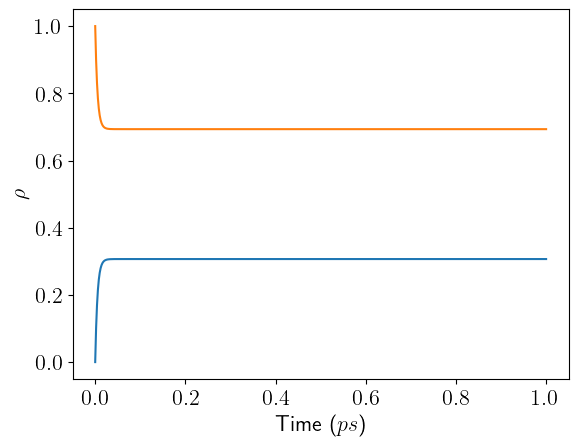

In [197]:
rho_spin_00 = tensor(basis(2,0)*basis(2,0).dag(), qeye(nph), qeye(nph), qeye(nph))
rho_spin_11 = tensor(basis(2,1)*basis(2,1).dag(), qeye(nph), qeye(nph), qeye(nph))
rho_p0_00 = tensor(qeye(2), basis(2,0)*basis(2,0).dag(), qeye(nph), qeye(nph))
rho_p0_11 = tensor(qeye(2), basis(2,1)*basis(2,1).dag(), qeye(nph), qeye(nph))
rho_p1_00 = tensor(qeye(2), qeye(nph), basis(2,0)*basis(2,0).dag(), qeye(nph))
rho_p1_11 = tensor(qeye(2), qeye(nph), basis(2,1)*basis(2,1).dag(), qeye(nph))
rho_p2_00 = tensor(qeye(2), qeye(nph), qeye(nph), basis(2,0)*basis(2,0).dag())
rho_p2_11 = tensor(qeye(2), qeye(nph), qeye(nph), basis(2,1)*basis(2,1).dag())


#rho11_vals = np.array([results200.states[k].full()[0,0] for k in range(len(tlist))])
#rho22_vals = np.array([results200.states[k].full()[1,1] for k in range(len(tlist))])
lim1=0

plt.rcParams['text.usetex'] = True 
plt.rcParams.update({'font.size': 16})
#plt.figure(figsize=(10,6))
#plt.plot(tlist, np.real(expect(rho_spin_00,results200.states)))
#plt.plot(tlist, np.real(expect(rho_spin_11,results200.states)))
plt.plot(tlist, np.real(expect(rho_p0_00,results200.states)))
plt.plot(tlist[lim1:], np.real(expect(rho_p0_11,results200.states)[lim1:]))
#plt.plot(tlist[lim1:], np.real(expect(rho_p1_00,results200.states)[lim1:]))
#plt.plot(tlist[lim1:], np.real(expect(rho_p1_11,results200.states)[lim1:]))
#plt.plot(tlist[lim1:], np.real(expect(rho_p2_00,results200.states)[lim1:]))
#plt.plot(tlist[lim1:], np.real(expect(rho_p2_11,results200.states)[lim1:]))

plt.xlabel(r"Time ($ps$)")
plt.ylabel(r"$\rho$")
#plt.yscale('log')
#plt.title("Evolution of density matrix elements at in isolated systemK")
#plt.legend([r"$spin_{00}$", r"$spin_{11}$", r"$p0_{00}$", r"$p0_{11}$"])
#plt.legend([r"$spin_{11}$", r"$p0_{11}$", r"$p1_{00}$", r"$p2_{00}$"], loc=4)
#plt.legend([r"$p0_{11}$"])
#plt.legend([r"$p1_{11}$"])
#plt.legend([r"$p2_{11}$"])
plt.show()

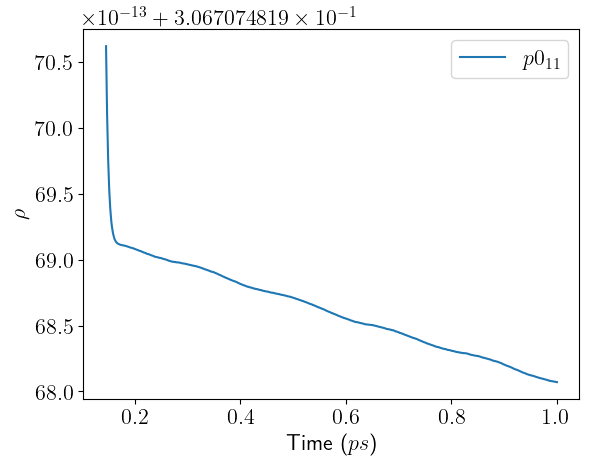

In [187]:
lim1=145

plt.rcParams['text.usetex'] = True 
plt.rcParams.update({'font.size': 16})
#plt.figure(figsize=(10,6))
#plt.plot(tlist, np.real(expect(rho_spin_00,results200.states)))
#plt.plot(tlist, np.real(expect(rho_spin_11,results200.states)))
#plt.plot(tlist, np.real(expect(rho_p0_00,results200.states)))
plt.plot(tlist[lim1:], np.real(expect(rho_p0_11,results200.states)[lim1:]))
#plt.plot(tlist[lim1:], np.real(expect(rho_p1_00,results200.states)[lim1:]))
#plt.plot(tlist[lim1:], np.real(expect(rho_p1_11,results200.states)[lim1:]))
#plt.plot(tlist[lim1:], np.real(expect(rho_p2_00,results200.states)[lim1:]))
#plt.plot(tlist[lim1:], np.real(expect(rho_p2_11,results200.states)[lim1:]))

plt.xlabel(r"Time ($ps$)")
plt.ylabel(r"$\rho$")
#plt.yscale('log')
#plt.title("Evolution of density matrix elements at in isolated systemK")
#plt.legend([r"$spin_{00}$", r"$spin_{11}$", r"$p0_{00}$", r"$p0_{11}$"])
#plt.legend([r"$spin_{11}$", r"$p0_{11}$", r"$p1_{00}$", r"$p2_{00}$"], loc=4)
plt.legend([r"$p0_{11}$"])
#plt.legend([r"$p1_{11}$"])
#plt.legend([r"$p2_{11}$"])
plt.show()

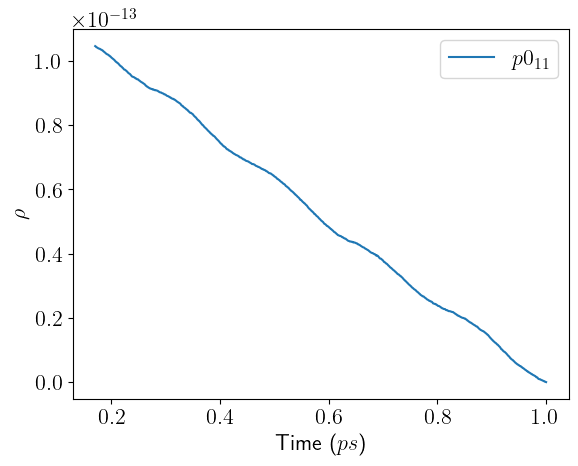

In [188]:
lim1=170

plt.rcParams['text.usetex'] = True 
plt.rcParams.update({'font.size': 16})
#plt.figure(figsize=(10,6))
#plt.plot(tlist, np.real(expect(rho_spin_00,results200.states)))
#plt.plot(tlist, np.real(expect(rho_spin_11,results200.states)))
#plt.plot(tlist, np.real(expect(rho_p0_00,results200.states)))
plt.plot(tlist[lim1:], np.abs(expect(rho_p0_11,results200.states)[lim1:])-np.min(np.abs(expect(rho_p0_11,results200.states)[lim1:])))
#plt.plot(tlist[lim1:], np.real(expect(rho_p1_00,results200.states)[lim1:]))
#plt.plot(tlist[lim1:], np.real(expect(rho_p1_11,results200.states)[lim1:]))
#plt.plot(tlist[lim1:], np.real(expect(rho_p2_00,results200.states)[lim1:]))
#plt.plot(tlist[lim1:], np.real(expect(rho_p2_11,results200.states)[lim1:]))

plt.xlabel(r"Time ($ps$)")
plt.ylabel(r"$\rho$")
#plt.yscale('log')
#plt.title("Evolution of density matrix elements at in isolated systemK")
#plt.legend([r"$spin_{00}$", r"$spin_{11}$", r"$p0_{00}$", r"$p0_{11}$"])
#plt.legend([r"$spin_{11}$", r"$p0_{11}$", r"$p1_{00}$", r"$p2_{00}$"], loc=4)
plt.legend([r"$p0_{11}$"])
#plt.legend([r"$p1_{11}$"])
#plt.legend([r"$p2_{11}$"])
plt.show()

In [189]:
pop = np.abs(expect(rho_p0_11,results200.states)[lim1:])-np.min(np.abs(expect(rho_p0_11,results200.states)[lim1:]))

In [190]:
slope = [max(pop)+x*(-max(pop)/(max(tlist[lim1:])-min(tlist[lim1:]))) for x in tlist[lim1:]]

In [191]:
pop1 = [pop[i]-slope[i] for i in range(len(tlist[lim1:]))]

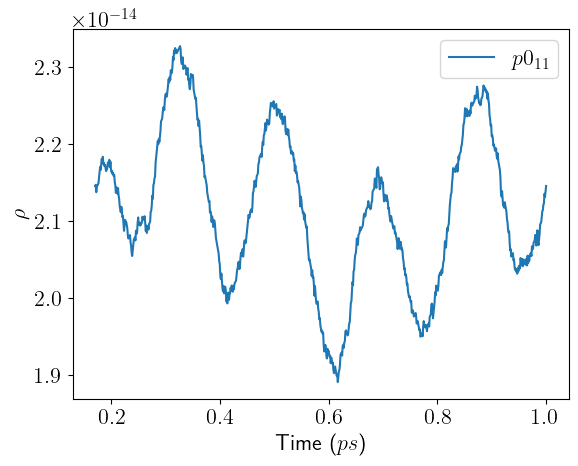

In [192]:
plt.plot(tlist[lim1:], pop1)
plt.xlabel(r"Time ($ps$)")
plt.ylabel(r"$\rho$")
#plt.yscale('log')
plt.legend([r"$p0_{11}$"])
plt.show()